# 1 Author
Name: Neeraj Yadav <br>


# 2 Problem Formulation
Building a machine learning pipeline, using the MILE END Sounds Data Set, which takes as input an audio segment and predicts whether that segment was recorded indoors or outdoors. 

# 3 Machine Learning Pipeline
1: Loading Data and Identifying Labels - The Dataset provided in MS Teams is uploaded to Google Drive. Based on the email correspondence, 6 files numbered 0033, 0381, 2201, 2203, 2205 and 2206 are removed as these files are corrupt. Then, all of the files (2494 in total) are analyzed for classifying labels. <br>
2: Feature Extraction - For the basic solution, the audio files are read and features power, pitch mean, pitch standard deviation, fraction of voiced region, spectral centroid, spectral bandwidth, spectral contrast and mfcc are extracted. <br>
3: Pipeline Modelling - The data are standardized and the machine learning model is implemented. <br>
3: Training/Analysis 
4: Validation/Analysis

We are using some of the code from the starter kit to set up data and process it.

In [31]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

We should have 2494 files since 6 out of 2500 were removed as they were corrupt and unsuitable for processing.

In [32]:
path = r'C:\Users\venkataramanan\Downloads\ml\ml\*.wav'
files = glob.glob(path)
len(files)

2494

In [33]:
MLENDLS_df = pd.read_csv(r'C:\Users\venkataramanan\Downloads\ml\MLEndLS.csv').set_index('file_id') 
MLENDLS_df

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176
...,...,...,...,...
2496.wav,westend,trafalgar,outdoor,S151
2497.wav,campus,square,outdoor,S6
2498.wav,westend,national,indoor,S96


In [34]:
for file in files:
  print(file.split('/')[-1])

C:\Users\venkataramanan\Downloads\ml\ml\0001.wav
C:\Users\venkataramanan\Downloads\ml\ml\0002.wav
C:\Users\venkataramanan\Downloads\ml\ml\0003.wav
C:\Users\venkataramanan\Downloads\ml\ml\0004.wav
C:\Users\venkataramanan\Downloads\ml\ml\0005.wav
C:\Users\venkataramanan\Downloads\ml\ml\0006.wav
C:\Users\venkataramanan\Downloads\ml\ml\0007.wav
C:\Users\venkataramanan\Downloads\ml\ml\0008.wav
C:\Users\venkataramanan\Downloads\ml\ml\0009.wav
C:\Users\venkataramanan\Downloads\ml\ml\0010.wav
C:\Users\venkataramanan\Downloads\ml\ml\0011.wav
C:\Users\venkataramanan\Downloads\ml\ml\0012.wav
C:\Users\venkataramanan\Downloads\ml\ml\0013.wav
C:\Users\venkataramanan\Downloads\ml\ml\0014.wav
C:\Users\venkataramanan\Downloads\ml\ml\0015.wav
C:\Users\venkataramanan\Downloads\ml\ml\0016.wav
C:\Users\venkataramanan\Downloads\ml\ml\0017.wav
C:\Users\venkataramanan\Downloads\ml\ml\0018.wav
C:\Users\venkataramanan\Downloads\ml\ml\0019.wav
C:\Users\venkataramanan\Downloads\ml\ml\0020.wav
C:\Users\venkatarama

# 4 Feature extraction

We extract the following features from the audio dataset. <br>
1.   Power. <br>
2.   Pitch - mean. <br>
3.   Pitch - standard deviation. <br>
4.   Fraction of voiced region. <br>
5.   Spectral Centrroid <br>
6.   Spectral Bandwidth <br>
7.   Spectral Contrast <br>
8.   MFCC <br>
We find the mean of these features. And, these features are appended to the list X (predictors). The label y in this case is binary i.e., 0 corresponds to outdoors and 1 corresponds to indoors.

In [35]:
#pitch of an audio signal
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [36]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('\\')[-1]
    file_name = file.split('\\')[-1]
    yi = labels_file.loc[fileID]['in_out']=='indoor'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    spec_centroid=np.mean(librosa.feature.spectral_centroid(y=x,sr=fs))
    spec_bandwidth=np.mean(librosa.feature.spectral_bandwidth(y=x,sr=fs))
    spec_contrast=np.mean(librosa.feature.spectral_contrast(y=x,sr=fs))
    mfcc=np.mean(librosa.feature.mfcc(y=x,sr=fs))

    xi = [power,pitch_mean,pitch_std,voiced_fr,spec_centroid,spec_bandwidth,spec_contrast,mfcc]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

We now apply `getXy` to entire data set and get predictor and label arrays. 

In [37]:
X,y = getXy(files, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 2494/2494 [40:06<00:00,  1.04it/s]


In [39]:
#Save the outputs to use later
np.save('X_basic.npy', X)
np.save('y_basic.npy', y)

The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [40]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (2494, 8)
The shape of y is (2494,)
The labels vector is [False  True False ...  True  True  True]


In [41]:
print(' The number of indoor recordings is ', np.count_nonzero(y))
print(' The number of outdoor recordings is ', y.size - np.count_nonzero(y))

 The number of indoor recordings is  1179
 The number of outdoor recordings is  1315


# 5 Methodology

Following methodology has ben used to build the model. <br>

1.   train_test_split: Data are split in 7:3 proportion for training and validation <br>
2.   Standard Scaler: z-score normalization is applied on the data so that no feature with large range of values dominates algorithms <br>
3.   We compute training and validation accuracy to test our models

# 6 Normalizing and Visualizing Dataset
Before any machine learning model is implemented, it is imperative that the data are standardized. We can perform this using the StandardScaler class.

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

s = StandardScaler()
X = s.fit_transform(X)
MLENDLS_df_features = pd.DataFrame(data=X, columns=['power','pitch_mean','pitch_std','voiced_fr','spectral_centroid','spectral_bandwidth','spectral_contrast','mfcc'])
MLENDLS_df_features['class'] = y
enc = LabelEncoder() 
MLENDLS_df_features["Target"] = enc.fit_transform(MLENDLS_df_features["class"])
MLENDLS_df_features['fileId'] = [file.split('\\')[-1] for file in files if file.split('\\')[-1] in MLENDLS_df.index]
MLENDLS_df_features.to_csv('MileEnd_DF_Features.csv')

In [50]:
MLENDLS_df_features.head()

,power,pitch_mean,pitch_std,voiced_fr,spectral_centroid,spectral_bandwidth,spectral_contrast,mfcc,class,Target,fileId
0,1.270302,-0.840896,-0.880589,-0.855506,0.969704,1.079002,-0.246406,1.918493,False,0,0001.wav
1,-0.312658,0.512150,0.626709,0.576658,-0.596170,-0.537630,0.806245,-0.519981,True,1,0002.wav
2,-0.738572,-0.439507,-0.382258,-0.389923,0.501195,0.270155,-0.619752,0.140253,False,0,0003.wav
3,0.286235,-0.321508,-0.144265,0.261876,0.516629,0.847039,-0.322517,-0.476240,True,1,0004.wav
4,-1.070913,0.098149,0.207105,-0.221206,-0.238468,-0.689238,-0.697768,-1.737288,False,0,0005.wav


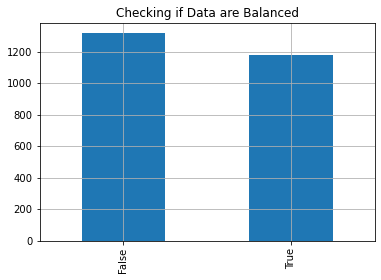

In [52]:
MLENDLS_df_features['class'].value_counts().plot(kind='bar')
plt.title('Checking if Data are Balanced')
plt.grid()
plt.show()

As we observe from the bar graph, the difference in number between 'True' and 'False' data is not very big. So, we can conclude that this dataset is relatively balanced.

# 7 Modeling: Support Vector Machines

We build a Support Vector Machine model to predict whether a given audio segment is indoor or outdoor.

In [54]:
#Load the outputs
X=np.load('X_basic.npy')
y=np.load('Y_basic.npy')

In [55]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1745, 8), (749, 8), (1745,), (749,))

The C paremeter in SVM deals with penalty for misclassification. The higher the C value, the more penalty is for misclassifying data.

In [56]:
model  = svm.SVC(C=5)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.5902578796561605
Validation  Accuracy 0.5861148197596796
The support vectors are (1588, 8)


We now normalize the predictors to check if there is any performance improvement.

In [57]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.9621776504297994
Validation  Accuracy 0.6181575433911882
The support vectors are (1649, 8)


# 7 Modeling: KNearestNeighbour

In [75]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train,y_train)

yt_p = knn.predict(X_train)
yv_p = knn.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.7472779369627507
Validation  Accuracy 0.6074766355140186


In [76]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

knn.fit(X_train,y_train)

yt_p = knn.predict(X_train)
yv_p = knn.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.7472779369627507
Validation  Accuracy 0.6074766355140186


# 8 Results
The KNearestNeighbour seems to perform better (higher validation accuracy) than the Support Vector Machine Model. 60 Percent Accuracy is reasonable given the limited amount of data and inconsistencies in it.